In [ ]:
# !open .

In [ ]:
import pandas as pd
import NeoQuant as nq
import requests

## get all company list

In [ ]:
companies = nq.get_all_company_list()
companies.index = 'A' + companies.index

## bond spread

In [ ]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

## get stock count

In [ ]:
import math

def get_total_stock_count(snapshot_tables):
    stock_count = 0

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])
    stock_count_info = info.loc['발행주식수(보통주/ 우선주)'][1]
    stock_counts = stock_count_info.split('/')
    for count in stock_counts:
#         print(count)
        stock_count = stock_count + int(count.replace(',',''))

    return stock_count

def get_self_stock_count(snapshot_tables):
    self_stock_count = 0
    info = snapshot_tables[4]
    info = info.set_index(info.columns[0])
    try:
        count = info.loc[['자기주식\xa0(자사주+자사주신탁)']]['보통주'][0] 
    except KeyError:
        count = 0
#     print(count)
    if not math.isnan(count):
        self_stock_count = int(count)
    return self_stock_count

# stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
# print('stock count : ' + str(stock_count))

def make_basic_df(snapshot_tables):
    average_stock_count = get_total_stock_count(snapshot_tables)
    self_stock_count = get_self_stock_count(snapshot_tables)

    basic_df = pd.DataFrame({'총주식수': average_stock_count, '자사주': self_stock_count}, index = [company_code])
    basic_df['주식수'] = basic_df['총주식수'] - basic_df['자사주']

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])

    price = int(info.loc['종가/ 전일대비'].iloc[0].split('/')[0].replace(',', ''))
    foreigner = float(info.loc['수익률(1M/ 3M/ 6M/ 1Y)'].iloc[2])
    total_asset = int(info.loc['시가총액(보통주,억원)'].iloc[0]) * 100000000
    basic_df['price'] = price
    basic_df['외국인'] = foreigner
    basic_df['시가총액'] = total_asset
    return basic_df

def make_fr_df(snapshot_tables):
    data_df = snapshot_tables[10]
    data_df.index = data_df[data_df.columns[0]]
    data_df.index.name = ''
    data_df.drop(data_df.columns[0], axis = 1, inplace = True)
    
#     data_df = data_df.set_index(data_df.columns[0])
    data_df = data_df['Annual']

    for num, name in enumerate(data_df.columns):
        temp_df = pd.DataFrame({company_code: data_df[name]})
        temp_df = temp_df.loc[['영업이익', '부채비율', '유보율', '지배주주지분', 'ROE', 'PER', 'PBR', '배당수익률']]
        temp_df = temp_df.T
        temp_df.columns = [[name] * len(temp_df.columns), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    return total_df


def request_fnguide_snapshot(company_code):
    if not company_code.startswith('A'):
        company_code = 'A' + company_code
    
    snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + company_code
    snapshot_page = requests.get(snapshot_url)
    snapshot_tables = pd.read_html(snapshot_page.text)
    return snapshot_tables

def get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration = 10):
    next_asset = asset
    ex_profits = []
    ex_profit_ratio = roe - expected_ratio
    next_roe = roe
    for _ in range(iteration):
        ex_profit_ratio = ex_profit_ratio * persist_factor
        next_roe = expected_ratio + ex_profit_ratio
        profit = next_asset * (next_roe / 100)
        ex_profit = next_asset * ex_profit_ratio / 100
        ex_profits.append(ex_profit)
        next_asset = next_asset + profit
    return ex_profits
def get_npv_profit(ex_profits, expected_ratio):
    npv_value = 0
    for num, ex_profit in enumerate(ex_profits):
        ex_profit = ex_profit *  1 / (1 + expected_ratio / 100) ** (num + 1)
#         print(ex_profit)
        npv_value = npv_value + ex_profit

    return npv_value

def get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration = 10):
    ex_profits = get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration)
    sum_of_profit = get_npv_profit(ex_profits, expected_ratio)
    return sum_of_profit

def get_more_adequate_price(asset, roe, expected_ratio, stock_count, persist_factor = 1, iteration = 10):
    accumulate_profit = get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration)
#     print(accumulate_profit)
    adequate_stock_price = asset + accumulate_profit
#     print(adequate_stock_price)
    price = (asset + accumulate_profit) / stock_count
    price = int(round(price))
    return price

def get_company_name(code, company_df):
    name = companies.loc[code]['company']
    if len(name) > 0:
        return name
    else:
        return ''


In [ ]:
company_name_list = ['이리츠코크렙', 'DL이앤씨', '맵스리얼티1']
# company_name_list = ['맵스리얼티1']

company_code_list = []
for company_name in company_name_list:
    company_code = nq.get_company_code(company_name, companies)
    if len(company_code) > 0:
        company_code_list.append(company_code)
    else:
        print('no company code with ' + company_name)
company_code_list

In [ ]:
company_code_list = companies.index

## get fnguide info

In [ ]:
import time
for num, company_code in enumerate(company_code_list):
    try:
        company_name = get_company_name(company_code, companies)
        print(num, company_code, company_name)

        time.sleep(1)

        try:
            snapshot_tables = request_fnguide_snapshot(company_code)
        except requests.exceptions.Timeout:
            time.sleep(60)
            snapshot_tables = fs_df = request_fnguide_snapshot(company_code)

        if len(snapshot_tables) < 10:
            print('>>>> not much data')
            continue
        temp_df = make_basic_df(snapshot_tables)
        temp_df['name'] = company_name
        if num == 0:
            basic_df = temp_df
        else:
            basic_df = pd.concat([basic_df, temp_df], sort=False)

        temp_df = make_fr_df(snapshot_tables)
        if num == 0:
            fr_df = temp_df
        else:
            fr_df = pd.concat([fr_df, temp_df], sort=False)
    except ValueError:
        print('>>>> ValueError')
        continue
    except TypeError:
        print('>>>> TypeError')
        continue
    except KeyError:
        print('>>>> KeyError')
        continue
    
        
#     if num == 20:
#         break


## save basic dataframe to excel

In [ ]:
basic_df.to_excel(r'data/basic_data.xlsx')

## load basic dataframe from excel

In [ ]:
basic_df = pd.read_excel(r'data/basic_data.xlsx')
basic_df.index = basic_df[basic_df.columns[0]]
basic_df.index.name = ''
basic_df.drop(basic_df.columns[0], axis = 1, inplace = True)

## save fr dataframe to excel

In [ ]:
fr_df.to_excel(r'data/fr_data.xlsx')

## load fr dataframe from excel

In [ ]:
fr_df = pd.read_excel(r'data/fr_data.xlsx')
fr_df.index = fr_df[fr_df.columns[0]]
fr_df.index.name = ''
fr_df.drop(fr_df.columns[0], axis = 1, inplace = True)
big_col = list(fr_df.columns)
small_col = list(fr_df.iloc[0])

new_big_col = []
for num, col in enumerate(big_col):
    if 'Unnamed' in col:
        new_big_col.append(new_big_col[num-1])
    else:
        new_big_col.append(big_col[num])

fr_df.columns = [new_big_col, small_col]
fr_df = fr_df.loc[ fr_df.index.dropna() ]

In [ ]:
expected_ratio = 7.91

## calculate adequate price

In [ ]:
for num, code in enumerate(fr_df.index):
    company_name = get_company_name(code, companies)
    print(num, code, company_name)
    for col in reversed(fr_df.columns.levels[0]):
#         print(fr_df[col]['ROE'])
        try:
            roe = pd.to_numeric(fr_df.loc[code][col]['ROE'])
            per = pd.to_numeric(fr_df.loc[code][col]['PER'])
            pbr = pd.to_numeric(fr_df.loc[code][col]['PBR'])
            asset = pd.to_numeric(fr_df.loc[code][col]['지배주주지분']) * 100000000
            debt_rate = pd.to_numeric(fr_df.loc[code][col]['부채비율'])
            keep_rate = pd.to_numeric(fr_df.loc[code][col]['유보율'])
            interest_rate = pd.to_numeric(fr_df.loc[code][col]['배당수익률'])

                
            if not math.isnan(roe) and not math.isnan(asset):
                print('standard date : ' + col)
                stock_count = basic_df.loc[code]['주식수']
                basic_df.at[code, '기준일'] = col
                basic_df.at[code, 'roe'] = roe
                basic_df.at[code, 'per'] = per
                basic_df.at[code, 'pbr'] = pbr
                basic_df.at[code, '부채비율'] = debt_rate
                basic_df.at[code, '유보율'] = keep_rate
                basic_df.at[code, '배당수익률'] = interest_rate
                
                basic_df.at[code, 'expectation'] = expected_ratio
    #             print('stock_count : ' + str(stock_count))
                high = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    #             print('high : ' + str(high))
                basic_df.at[code, 'high'] = high
                middle = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
                basic_df.at[code, 'middle'] = middle
                low = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)
                basic_df.at[code, 'low'] = low
                break
        except ValueError:
            print('>>> ValueError')
            continue


basic_df['dis_rate'] = basic_df['price'] / basic_df['low']
basic_df = basic_df.sort_values(by='dis_rate', ascending=True)

## make report

In [ ]:
final_df = basic_df
final_df = final_df.loc[~final_df.index.str.startswith('A9')]
final_df['dis_rate'] = final_df['price'] / final_df['low']
final_df = final_df.sort_values(by='dis_rate', ascending=True)

In [ ]:
final_df = final_df.loc[final_df['dis_rate'] > 0.1]

final_df = final_df.loc[final_df['dis_rate'] < 1]

final_df = final_df.loc[final_df['roe'] > final_df['expectation']]
# final_df = final_df.loc[final_df['roe'] > 10]

final_df = final_df.loc[final_df['roe'] < 50]

final_df = final_df.loc[final_df['시가총액'] > 1000 * 100000000]

In [ ]:
final_df = final_df.loc[final_df['배당수익률'] > 1]

In [ ]:
final_df = final_df.loc[~final_df['name'].str.contains('홀딩스')]

In [ ]:
final_df = final_df.loc[final_df['roe'] > 10]

In [ ]:
len(final_df)

In [ ]:
final_df.to_excel(r'data/port_data.xlsx')

## show chart

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


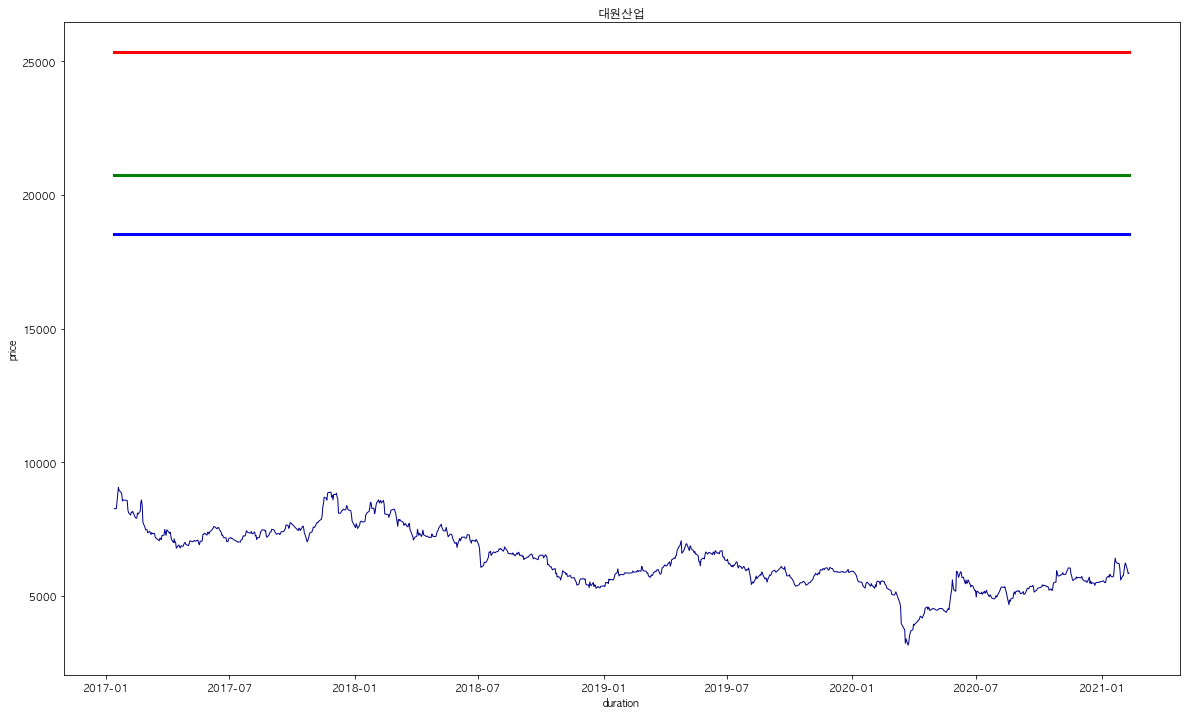

In [54]:
company_name = '대원산업'
company_code = nq.get_company_code(company_name, companies)


price_df = nq.request_price_list(company_code, 'day', 1000)

price_high = basic_df.loc[company_code]['high']
price_middle = basic_df.loc[company_code]['middle']
price_low = basic_df.loc[company_code]['low']

price_df['price_low'] = [price_low] * len(price_df)
price_df['price_middle'] = [price_middle] * len(price_df)
price_df['price_high'] = [price_high] * len(price_df)

nq.show_price_chart(company_code, company_name, price_df)